### Linear Model
Use the 37GHz V-pol band to predict ERA5 skin temperature (Both for Ascending and Descending passes)

In [31]:
from sklearn.linear_model import LinearRegression, HuberRegressor

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize, CenteredNorm
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors

import xarray as xr
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '../..')))

from src.processing import windsat_datacube, create_landmask

In [2]:
# Load
ws_path = "../../data/raw/daily_Windsat/"
wsds = windsat_datacube(ws_path)

igbp_path = "../../data/processed/IGBP_WindsatGrid.h5"
igbp_ds = xr.open_dataset(igbp_path)

# Use the IGBP classification and select all classes by 0 "water". It also removes big lakes.
wsds["IGBP"] = (("latitude_grid","longitude_grid"),igbp_ds.IGBP.values)
wsds = wsds.where(wsds.IGBP != 0)

# Map grid to lat-lon for plotting
wsds = wsds.swap_dims(
    {
        "latitude_grid": "lat",
        "longitude_grid": "lon",
    }
)
wsds = wsds.sortby(['lat', 'lon'])

# Select TbToA for  Ka V pol band, alongise the objective temperature
selection ={
    "polarization": 1, # 1 - Vertical
    "frequency_band": 1 # 1 - 37GHz
}
dvar_selection = ["tbtoa","surtep_ERA5"]
tbs = wsds.sel(**selection).reset_coords()[dvar_selection]

#Ascending vs descendig model
asc_tbs = tbs.sel(swath_sector = 0)
des_tbs = tbs.sel(swath_sector = 1)

datasets = [asc_tbs, des_tbs]


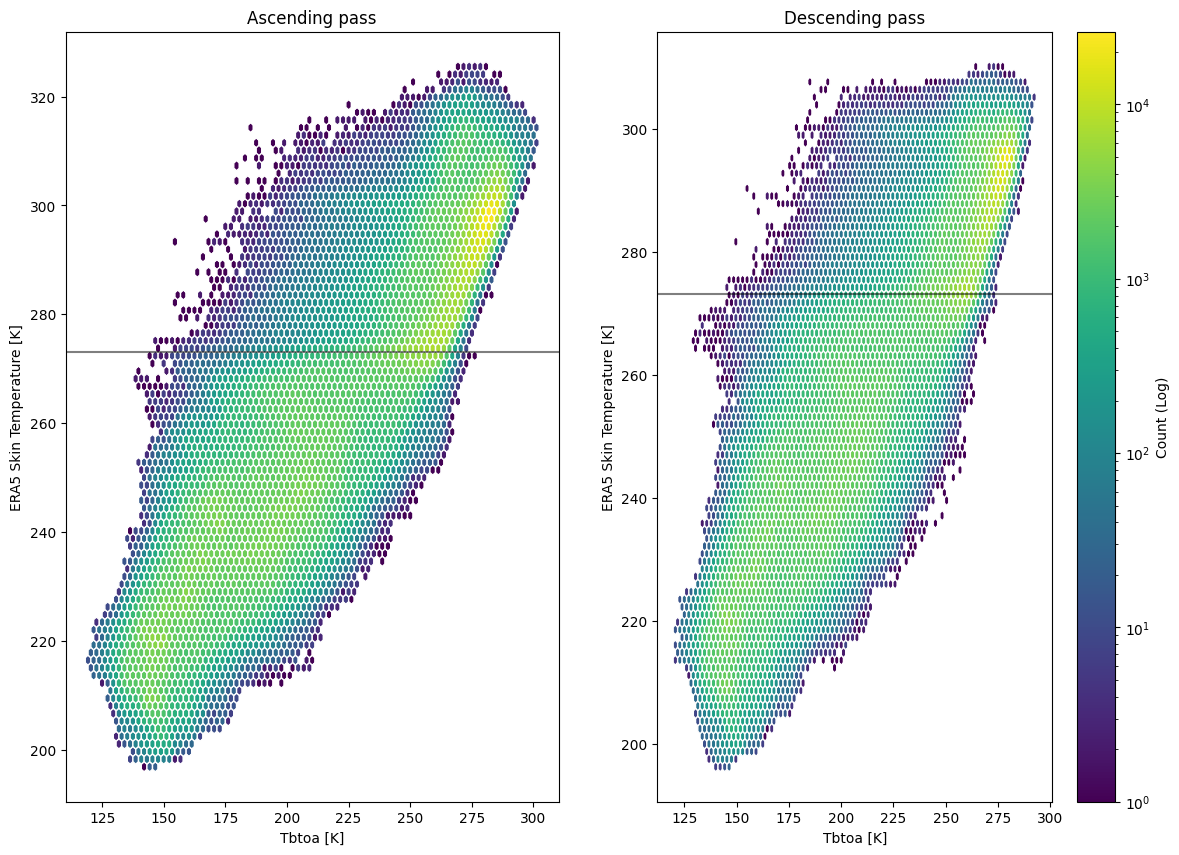

In [3]:
# All data plots:

fig, axs = plt.subplots(1,2, figsize = (14,10))

hexbinnorm = LogNorm(vmin= 1)
hexbin_kw = {
    "gridsize" : 80,
    "alpha" : 1,
    "edgecolors": "White",
    "norm" : hexbinnorm

}
regression_kw = {
    "color" : "Red",
    "alpha" : 0.7,
    "linestyle" : "--"
}
index2pass = {
    0 : "Ascending",
    1 : "Descending",
}

for i, ds in enumerate(datasets):
    ax = axs[i]
    df = ds.to_dataframe().reset_index(drop=True).dropna()
    
    ax.hexbin(x = df["tbtoa"], y = df["surtep_ERA5"], **hexbin_kw)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    ax.axline((0,273.15), slope= 0, color = "Black", alpha = 0.5)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.set_xlabel("Tbtoa [K]")
    ax.set_ylabel("ERA5 Skin Temperature [K]")
    ax.set_title(f"{index2pass[i]} pass")

cbar = plt.colorbar(ScalarMappable(norm=hexbinnorm, cmap="viridis"), ax=ax, orientation='vertical', pad=0.05, label = "Count (Log)")

In [4]:

# Linear regression with each swath sector:
regs = []

# Select temperatures avobe 2ºC, the Holmes hipotheisys states that the valid range for TBs is 259.8 K
corrected_datasets = [ds.where(ds.tbtoa > (259.8)) for ds in datasets]
corrected_datasets = [ds.where(ds.surtep_ERA5 > (273.15 + 2)) for ds in corrected_datasets]

dataframes = [ds.to_dataframe().reset_index(drop=True).dropna() for ds in corrected_datasets]
for df in dataframes:

    X=df["tbtoa"].values.reshape(-1, 1)
    y=df["surtep_ERA5"].values
    
    reg = LinearRegression()
    reg.fit(X, y)
    regs.append(reg)

    # Evaluate the model
    linear_score = reg.score(X, y)
    print("Model score:", linear_score)
    print(reg.intercept_, reg.coef_)


Model score: 0.24231882074113686
140.40352 [0.5619215]
Model score: 0.2801316720201278
143.68117 [0.53977954]


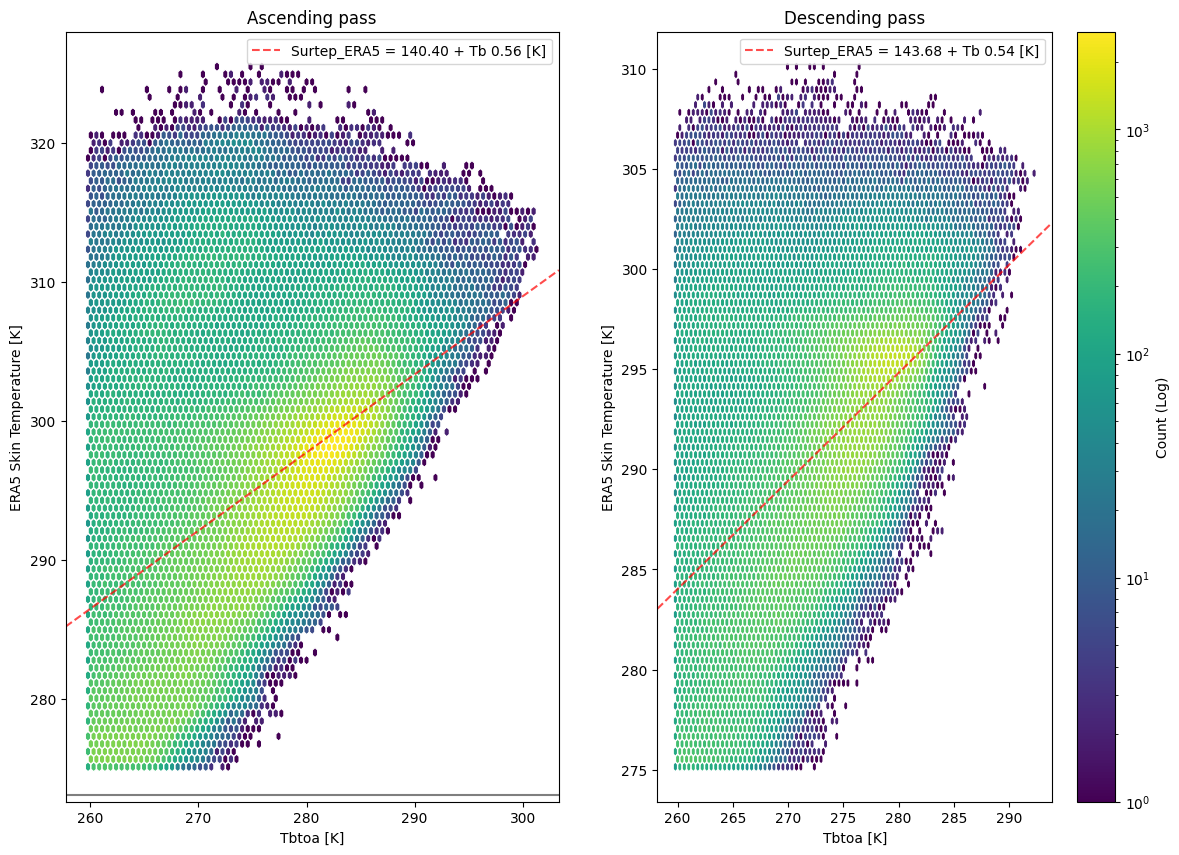

In [5]:
# Plots of corrected data:
fig, axs = plt.subplots(1,2, figsize = (14,10))

hexbinnorm = LogNorm(vmin= 1)
# hexbinnorm = Normalize()
hexbin_kw = {
    "gridsize" : 80,
    "alpha" : 1,
    "edgecolors": "White",
    "norm" : hexbinnorm

}
regression_kw = {
    "color" : "Red",
    "alpha" : 0.7,
    "linestyle" : "--"
}
index2pass = {
    0 : "Ascending",
    1 : "Descending",
}

for i, df in enumerate(dataframes):
    reg = regs[i]
    ax = axs[i]
    
    ax.hexbin(x = df["tbtoa"], y = df["surtep_ERA5"], **hexbin_kw)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    ax.axline((0,273.15), slope= 0, color = "Black", alpha = 0.5)
    reg_label = f"Surtep_ERA5 = {reg.intercept_:.2f} + Tb {reg.coef_[0]:.2f} [K]"
    ax.axline((0,reg.intercept_), slope= reg.coef_[0], **regression_kw, label=reg_label)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.set_xlabel("Tbtoa [K]")
    ax.set_ylabel("ERA5 Skin Temperature [K]")
    ax.set_title(f"{index2pass[i]} pass")

    ax.legend()


cbar = plt.colorbar(ScalarMappable(norm=hexbinnorm, cmap="viridis"), ax=ax, orientation='vertical', pad=0.05, label = "Count (Log)")




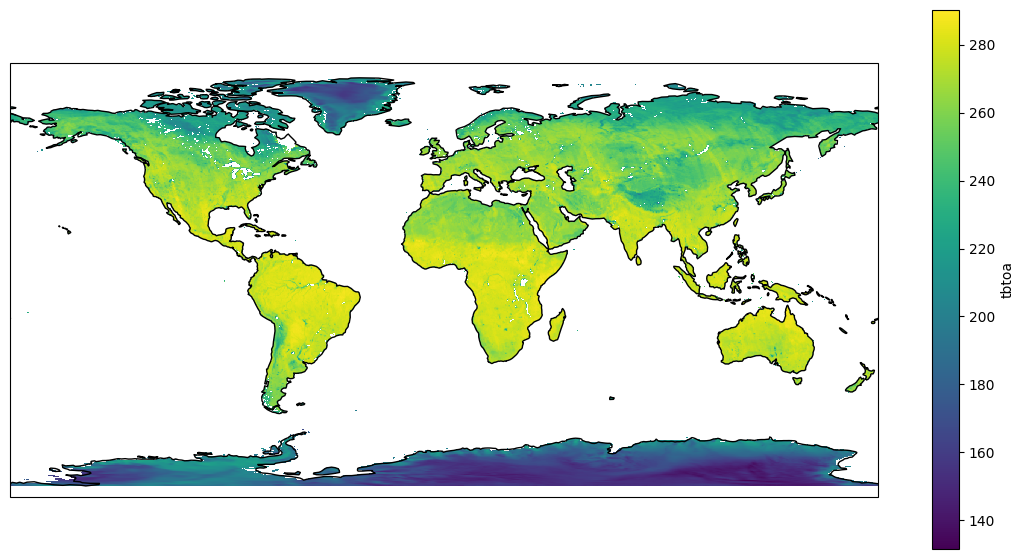

In [6]:
import cartopy.crs as ccrs
fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection": ccrs.PlateCarree()})

asc_tbs.tbtoa.mean(dim="day_number").plot()
ax.coastlines()

In [7]:
# TODO: add a map of the errrors to see what is happening

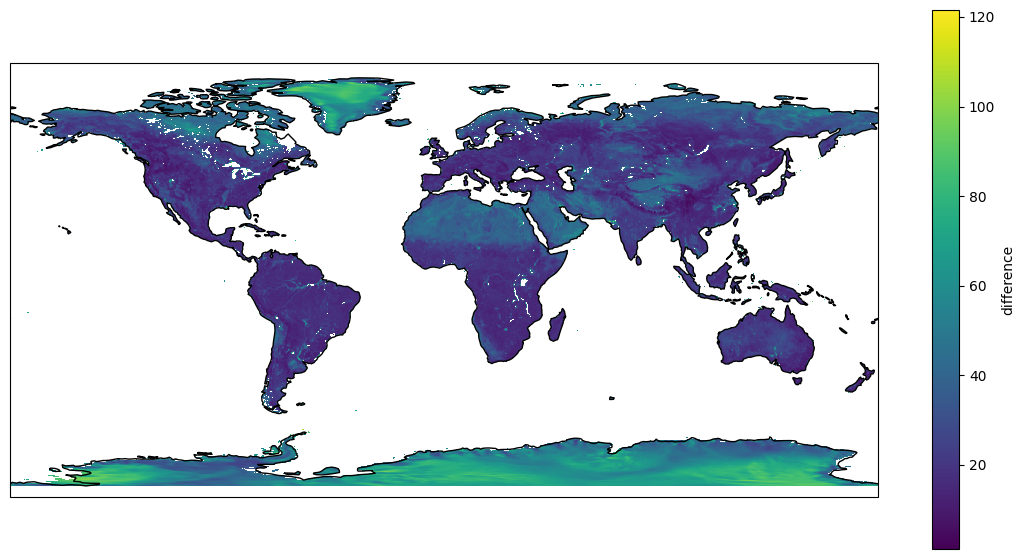

In [8]:
import cartopy.crs as ccrs
fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection": ccrs.PlateCarree()})

# TODO, this is too much, scatter is not the way to go
ds = datasets[0]
ds["difference"] = ds.surtep_ERA5 - ds.tbtoa
ds.difference.mean(dim="day_number").plot()

ax.coastlines()

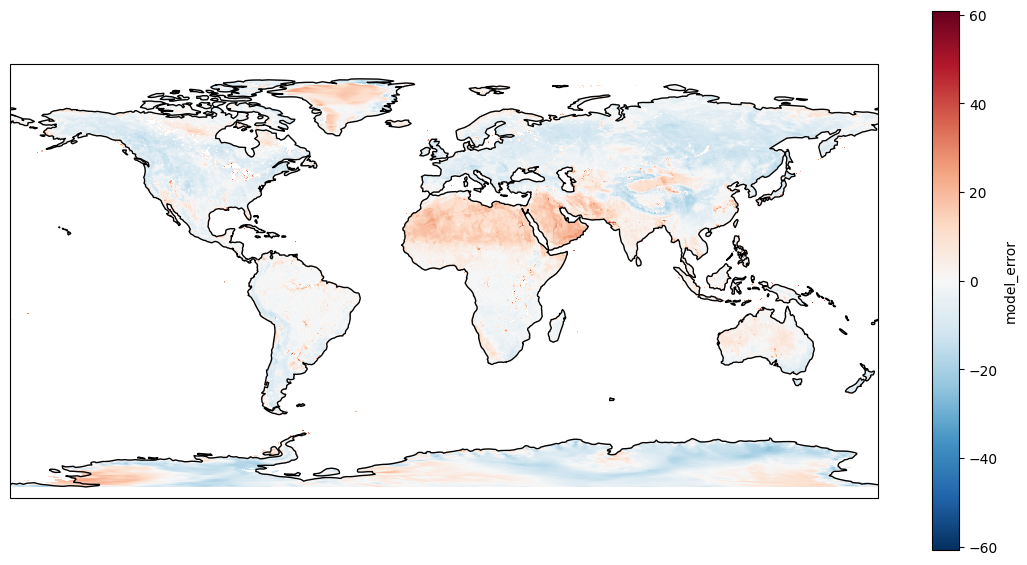

In [9]:
# Calculate the model output using apply_ufunc

reg = regs[0]
ds["model_prediction"] = ds["tbtoa"] * reg.coef_ + reg.intercept_
ds["model_error"] = ds.surtep_ERA5 - ds.model_prediction

fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()

ds.model_error.mean(dim="day_number").plot()

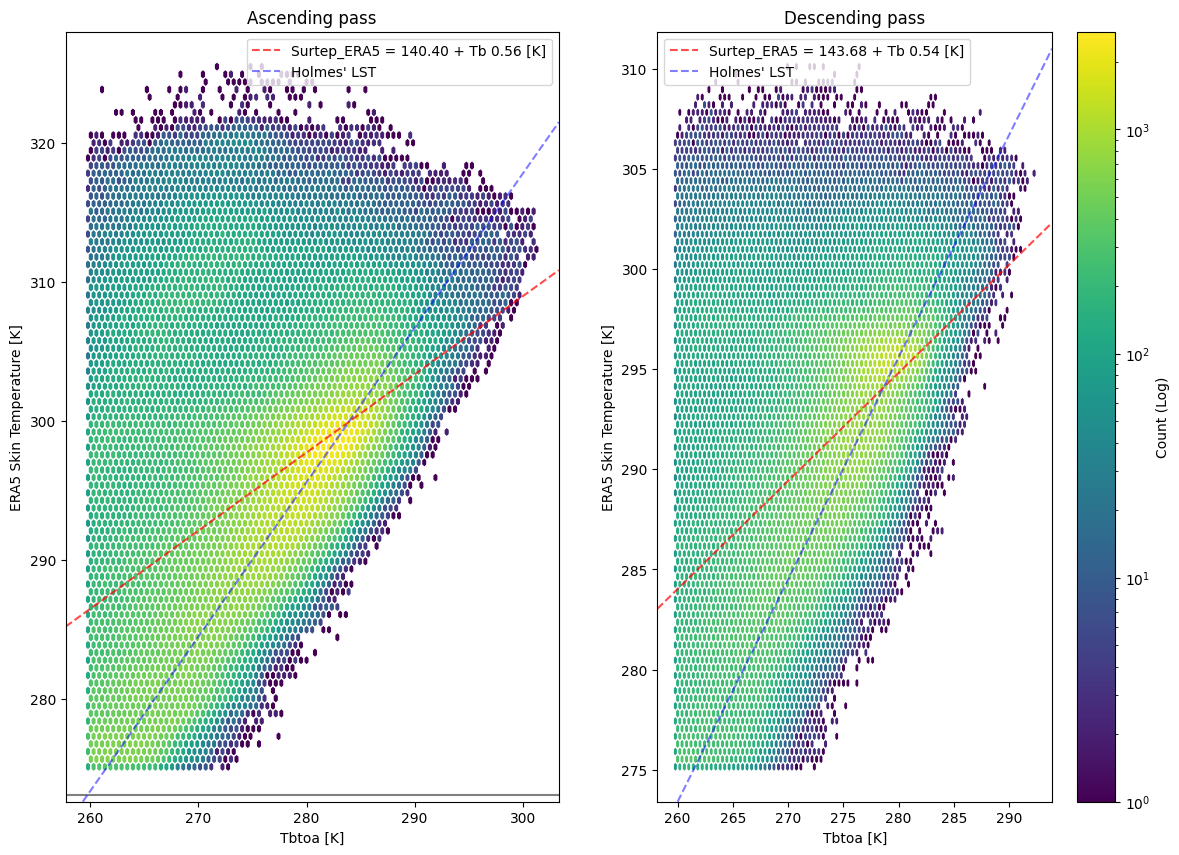

In [10]:
# Apply Holmes' original coefficients and see.

# Plots of corrected data:
fig, axs = plt.subplots(1,2, figsize = (14,10))

hexbinnorm = LogNorm(vmin= 1)
# hexbinnorm = Normalize()
hexbin_kw = {
    "gridsize" : 80,
    "alpha" : 1,
    "edgecolors": "White",
    "norm" : hexbinnorm

}
regression_kw = {
    "color" : "Red",
    "alpha" : 0.7,
    "linestyle" : "--"
}
index2pass = {
    0 : "Ascending",
    1 : "Descending",
}

for i, df in enumerate(dataframes):
    reg = regs[i]
    ax = axs[i]
    
    ax.hexbin(x = df["tbtoa"], y = df["surtep_ERA5"], **hexbin_kw)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    ax.axline((0,273.15), slope= 0, color = "Black", alpha = 0.5)
    reg_label = f"Surtep_ERA5 = {reg.intercept_:.2f} + Tb {reg.coef_[0]:.2f} [K]"
    ax.axline((0,reg.intercept_), slope= reg.coef_[0], **regression_kw, label=reg_label)

    # Holmes' regression coefficients
    ax.axline((0,-15.2), slope = 1.11, color = "Blue", label ="Holmes' LST", alpha = 0.5, linestyle = "--")

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.set_xlabel("Tbtoa [K]")
    ax.set_ylabel("ERA5 Skin Temperature [K]")
    ax.set_title(f"{index2pass[i]} pass")

    ax.legend()


cbar = plt.colorbar(ScalarMappable(norm=hexbinnorm, cmap="viridis"), ax=ax, orientation='vertical', pad=0.05, label = "Count (Log)")




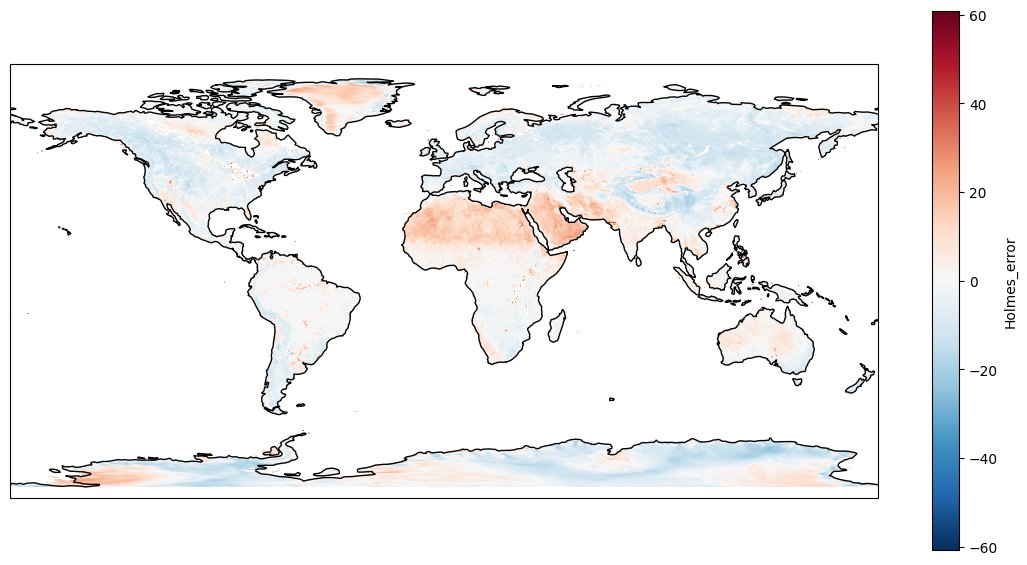

In [11]:
# Plot the map error:
# Calculate the model output using apply_ufunc
ds["Holmes_prediction"] = ds["tbtoa"] * 1.11 + (-15.2)
ds["Holmes_error"] = ds.surtep_ERA5 - ds.model_prediction

fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()

ds.Holmes_error.mean(dim="day_number").plot()

In [30]:
# Ascending vs descending model comparison 
swathid = 0

reg = regs[swathid]
ds = corrected_datasets[swathid]

ds["model_prediction"] = ds["tbtoa"] * reg.coef_ + reg.intercept_
ds["model_error"] = ds.surtep_ERA5 - ds.model_prediction

ds["Holmes_prediction"] = ds["tbtoa"] * 1.11 + (-15.2)
ds["Holmes_error"] = ds.surtep_ERA5 - ds.Holmes_prediction


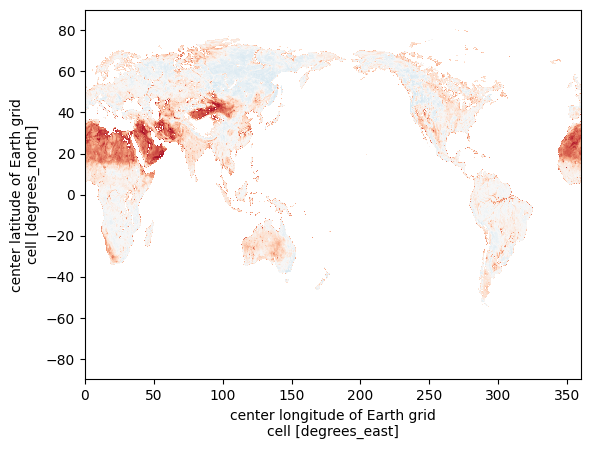

In [39]:
ds.Holmes_error.mean("day_number").plot(add_colorbar = False)

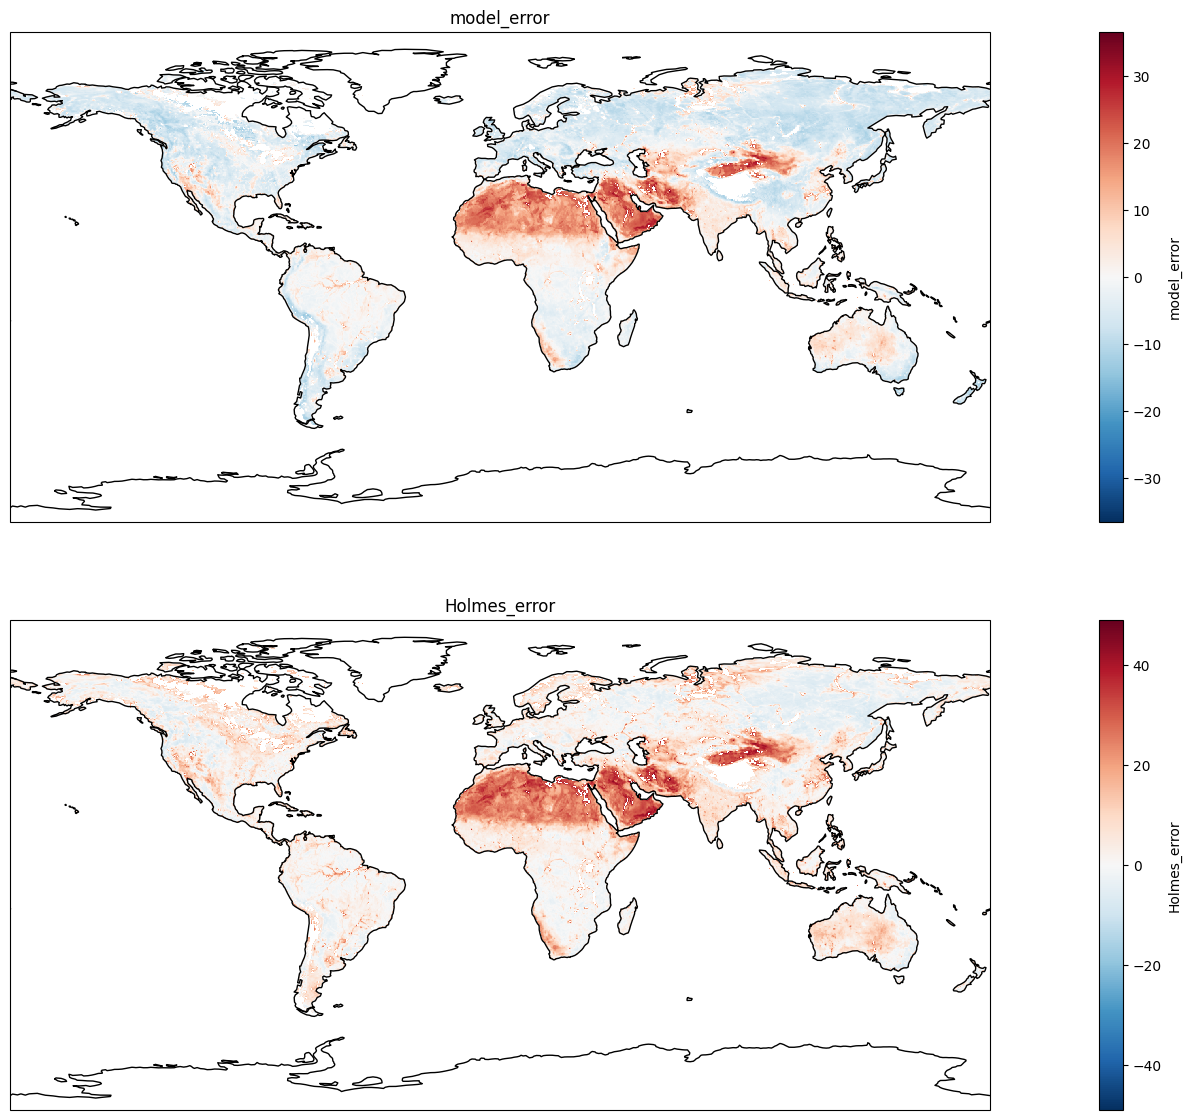

In [55]:
fig, axs = plt.subplots(2,1,figsize = (28,14), subplot_kw={"projection": ccrs.PlateCarree()})

ax = axs[0]
ax.coastlines()
ds.model_error.mean(dim="day_number").plot(ax=axs[0], add_colorbar=True)
ax.set_title("model_error")


ax = axs[1]
ax.coastlines()
ds.Holmes_error.mean(dim="day_number").plot(ax=axs[1], add_colorbar=True)
ax.set_title("Holmes_error")



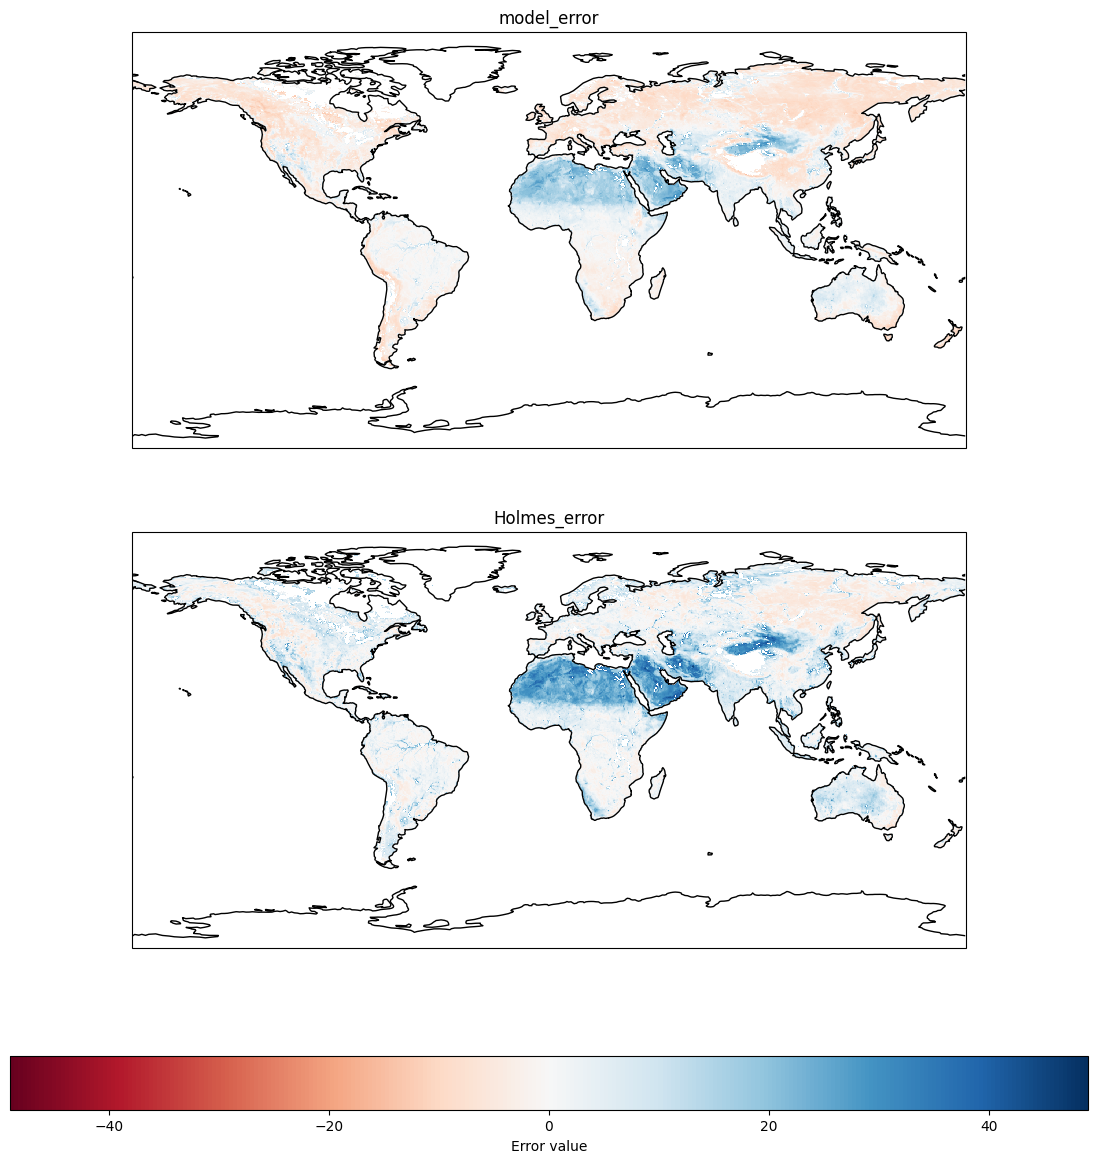

In [61]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Calcular los valores mínimos y máximos de los arrays usando .compute()
model_error_mean = ds.model_error.mean(dim="day_number").compute()
holmes_error_mean = ds.Holmes_error.mean(dim="day_number").compute()

# Obtener los valores absolutos máximos para centrar la escala en 0
vmax = max(abs(model_error_mean.min().item()), abs(model_error_mean.max().item()), 
           abs(holmes_error_mean.min().item()), abs(holmes_error_mean.max().item()))
vmin = -vmax

# Crear la figura y los ejes
fig, axs = plt.subplots(2, 1, figsize=(28, 14), subplot_kw={"projection": ccrs.PlateCarree()})

# Graficar el primer mapa
ax = axs[0]
ax.coastlines()
im1 = model_error_mean.plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax, cmap='RdBu')
ax.set_title("model_error")

# Graficar el segundo mapa
ax = axs[1]
ax.coastlines()
im2 = holmes_error_mean.plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax, cmap='RdBu')
ax.set_title("Holmes_error")

# Añadir una sola colorbar para ambas gráficas
cbar = fig.colorbar(im1, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label('Error value')

plt.show()
